In [1]:
#PART1 - Converting WIKI table into PANDA DATAFRAME
# Import libraries
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

# Webscrapping the URL
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

soup = BeautifulSoup(source, 'html5lib')

In [2]:
postalcodedict = {} # initialize an empty dictionary to save the data in
for table_cell in soup.find_all('td'):
    try:
        postal_code = table_cell.p.b.text # get the postal code
        postal_code_investigate = table_cell.span.text
        neighborhoods_data = table_cell.span.text # get the rest of the data in the cell
        borough = neighborhoods_data.split('(')[0] # get the borough in the cell
        
        # if the cell is not assigned then ignore it
        if neighborhoods_data == 'Not assigned':
            neighborhoods = []
        # else process the data and add it to the dictionary
        else:
            postalcodedict[postal_code] = {}
            
            try:
                neighborhoods = neighborhoods_data.split('(')[1]
            
                # remove parantheses from neighborhoods string
                neighborhoods = neighborhoods.replace('(', ' ')
                neighborhoods = neighborhoods.replace(')', ' ')

                neighborhoods_names = neighborhoods.split('/')
                neighborhoods_clean = ', '.join([name.strip() for name in neighborhoods_names])
            except:
                borough = borough.strip('\n')
                neighborhoods_clean = borough
 
            # add borough and neighborhood to dictionary
            postalcodedict[postal_code]['borough'] = borough
            postalcodedict[postal_code]['neighborhoods'] = neighborhoods_clean
    except:
        pass

In [3]:
# empty dataframe
columns = ['PostalCode', 'Borough', 'Neighborhood']
torontodata = pd.DataFrame(columns=columns)
torontodata

Empty DataFrame
Columns: [PostalCode, Borough, Neighborhood]
Index: []

In [6]:
# add values into dataframe
for ind, postal_code in enumerate(postalcodedict):
    borough = postalcodedict[postal_code]['borough']
    neighborhood = postalcodedict[postal_code]['neighborhoods']
    torontodata = torontodata.append({"PostalCode": postal_code, 
                                        "Borough": borough, 
                                        "Neighborhood": neighborhood},
                                        ignore_index=True)


torontodata

PostalCode                                            Borough  \
0          M3A                                         North York   
1          M4A                                         North York   
2          M5A                                   Downtown Toronto   
3          M6A                                         North York   
4          M7A                                       Queen's Park   
..         ...                                                ...   
98         M8X                                          Etobicoke   
99         M4Y                                   Downtown Toronto   
100        M7Y  East TorontoBusiness reply mail Processing Cen...   
101        M8Y                                          Etobicoke   
102        M8Z                                          Etobicoke   

                                          Neighborhood  
0                                            Parkwoods  
1                                     Victoria Village  
2                            Regent Park, Harbourfront  
3                     Lawrence Manor, Lawrence Heights  
4                        Ontario Provincial Government  
..                                                 ...  
98       The Kingsway, Montgomery Road, Old Mill North  
99                                Church and Wellesley  
100                                     Enclave of M4L  
101  Old Mill South, King's Mill Park, Sunnylea, Hu...  
102  Mimico NW, The Queensway West, South of Bloor,...  

[103 rows x 3 columns]

In [10]:
# PART 2 - MERGING IT WITH GEOSPATIAL DATA BEING PROVIDED
# Reading it from the geo file -http://cocl.us/Geospatial_data
print(type(torontodata))
geodf = pd.read_csv('./Geospatial_Coordinates.csv')
geodf.columns = ['GeoPostCode','Latitude', 'Longitude']

<class 'pandas.core.frame.DataFrame'>


In [11]:
print(geodf.head())
print(geodf.tail())

  GeoPostCode   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476
    GeoPostCode   Latitude  Longitude
98          M9N  43.706876 -79.518188
99          M9P  43.696319 -79.532242
100         M9R  43.688905 -79.554724
101         M9V  43.739416 -79.588437
102         M9W  43.706748 -79.594054


In [13]:
Concatdf = pd.concat([torontodata,geodf], axis=1)
finalgeodf=Concatdf.drop(['GeoPostCode'] , axis=1)
finalgeodf.head()
# End of Part2

PostalCode           Borough                      Neighborhood   Latitude  \
0        M3A        North York                         Parkwoods  43.806686   
1        M4A        North York                  Victoria Village  43.784535   
2        M5A  Downtown Toronto         Regent Park, Harbourfront  43.763573   
3        M6A        North York  Lawrence Manor, Lawrence Heights  43.770992   
4        M7A      Queen's Park     Ontario Provincial Government  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

In [14]:
# PART 3 - Explore and cluster the neighborhoods in Toronto. You can decide to work with only boroughs that contain the word Toronto 

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.9.2                |   py38h50d1736_0         3.1 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.1.0                |     pyhd3deb0d_0          64 KB  conda-forge
    python_abi-3.8             |           1_cp38           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.2 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.1.0-pyhd3deb0d_0
  python_abi         conda-forge/osx-64::python_abi-3.8-1_cp38

The following packages will be SUPERSEDED by 

In [15]:
address = 'Toronto, CA'
geolocator = Nominatim(user_agent="Toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [16]:
# Extracting those boroughs which got Toronto in it from the original data frame finalgeodf
finalgeodf.head()
Torontogeodf = finalgeodf.loc[finalgeodf['Borough'].str.contains('Toronto')].reset_index()
Torontogeodf.shape
Torontogeodf

index PostalCode                                            Borough  \
0       2        M5A                                   Downtown Toronto   
1       9        M5B                                   Downtown Toronto   
2      15        M5C                                   Downtown Toronto   
3      19        M4E                                       East Toronto   
4      20        M5E                                   Downtown Toronto   
5      24        M5G                                   Downtown Toronto   
6      25        M6G                                   Downtown Toronto   
7      30        M5H                                   Downtown Toronto   
8      31        M6H                                       West Toronto   
9      35        M4J                              East YorkEast Toronto   
10     36        M5J                                   Downtown Toronto   
11     37        M6J                                       West Toronto   
12     41        M4K                                       East Toronto   
13     42        M5K                                   Downtown Toronto   
14     43        M6K                                       West Toronto   
15     47        M4L                                       East Toronto   
16     48        M5L                                   Downtown Toronto   
17     54        M4M                                       East Toronto   
18     61        M4N                                    Central Toronto   
19     62        M5N                                    Central Toronto   
20     67        M4P                                    Central Toronto   
21     68        M5P                                    Central Toronto   
22     69        M6P                                       West Toronto   
23     73        M4R                                    Central Toronto   
24     74        M5R                                    Central Toronto   
25     75        M6R                                       West Toronto   
26     79        M4S                                    Central Toronto   
27     80        M5S                                   Downtown Toronto   
28     81        M6S                                       West Toronto   
29     83        M4T                                    Central Toronto   
30     84        M5T                                   Downtown Toronto   
31     86        M4V                                    Central Toronto   
32     87        M5V                                   Downtown Toronto   
33     91        M4W                                   Downtown Toronto   
34     92        M5W     Downtown TorontoStn A PO Boxes25 The Esplanade   
35     96        M4X                                   Downtown Toronto   
36     97        M5X                                   Downtown Toronto   
37     99        M4Y                                   Downtown Toronto   
38    100        M7Y  East TorontoBusiness reply mail Processing Cen...   

                                         Neighborhood   Latitude  Longitude  
0                           Regent Park, Harbourfront  43.763573 -79.188711  
1                            Garden District, Ryerson  43.692657 -79.264848  
2                                      St. James Town  43.799525 -79.318389  
3                                         The Beaches  43.786947 -79.385975  
4                                         Berczy Park  43.757490 -79.374714  
5                                  Central Bay Street  43.782736 -79.442259  
6                                            Christie  43.753259 -79.329656  
7                            Richmond, Adelaide, King  43.737473 -79.464763  
8                        Dufferin, Dovercourt Village  43.739015 -79.506944  
9                                  The Danforth  East  43.706397 -79.309937  
10  Harbourfront East, Union Station, Toronto Islands  43.695344 -79.318389  
11                           Little Portugal, Trinity  43.676357 -7

In [18]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(Torontogeodf['Latitude'], Torontogeodf['Longitude'], Torontogeodf['Borough'], Torontogeodf['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

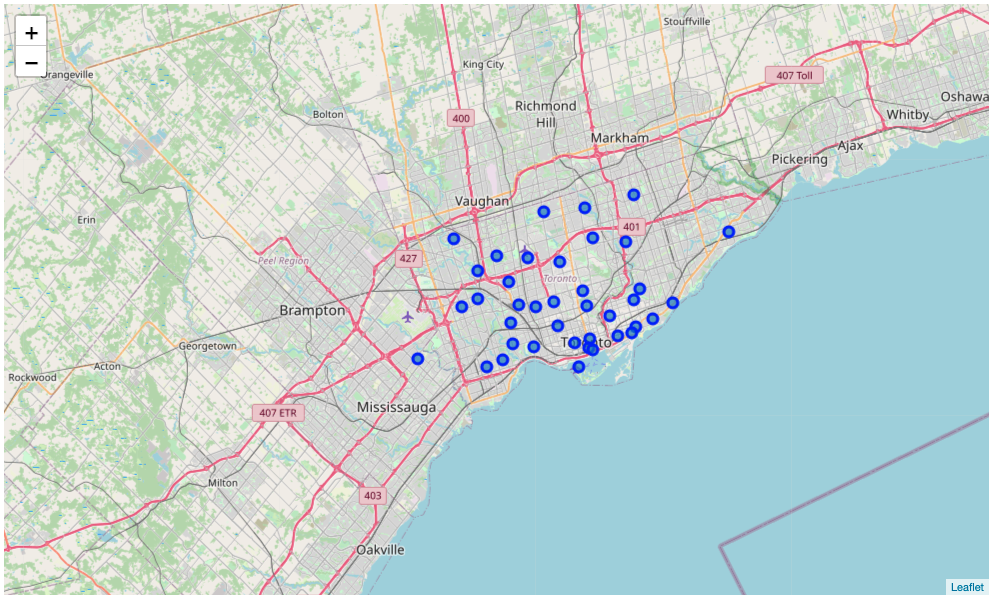

In [19]:
# Exploring Venues using FourSquare
CLIENT_ID = 'HL3OSM3ZW0A1INBQ5YXRPVGJ3EPZUDWIE0MEHCWAAET4WMX3' # your Foursquare ID
CLIENT_SECRET = 'KRB4ACCSJ0JMN0J4G0W3RZ0BOCCFM0FEYSI0F5ZBTTJC4DQF' # your Foursquare Secret
VERSION = '20180604' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HL3OSM3ZW0A1INBQ5YXRPVGJ3EPZUDWIE0MEHCWAAET4WMX3
CLIENT_SECRET:KRB4ACCSJ0JMN0J4G0W3RZ0BOCCFM0FEYSI0F5ZBTTJC4DQF


In [21]:
# Exploring the Venues nearby the Neighbourhood - Rosedale in Downtown TOronto
Torontogeodf.loc[10,'Neighborhood']

'Harbourfront East, Union Station, Toronto Islands'

In [22]:
neighborhood_latitude = Torontogeodf.loc[10, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Torontogeodf.loc[10, 'Longitude'] # neighborhood longitude value

neighborhood_name = Torontogeodf.loc[10, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Harbourfront East, Union Station, Toronto Islands are 43.695343900000005, -79.3183887.


In [23]:

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=HL3OSM3ZW0A1INBQ5YXRPVGJ3EPZUDWIE0MEHCWAAET4WMX3&client_secret=KRB4ACCSJ0JMN0J4G0W3RZ0BOCCFM0FEYSI0F5ZBTTJC4DQF&v=20180604&ll=43.695343900000005,-79.3183887&radius=500&limit=100'

In [24]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '605f71d18c83b6316ecb193d'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Toronto',
  'headerFullLocation': 'Toronto',
  'headerLocationGranularity': 'city',
  'totalResults': 7,
  'suggestedBounds': {'ne': {'lat': 43.69984390450001,
    'lng': -79.31217644853614},
   'sw': {'lat': 43.6908438955, 'lng': -79.32460095146386}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b575507f964a520e03128e3',
       'name': 'East York Memorial Arena',
       'location': {'address': '888 Cosburn Ave.',
        'crossStreet': 'Woodbine',
        'lat': 43.69722441688202,
        'lng': -79.31539709142582,
        'labeledLatLngs': [{'label': 'display',
   

In [25]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


In [26]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

<ipython-input-26-561c05f0fdd1>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


name    categories        lat        lng
0  East York Memorial Arena  Skating Rink  43.697224 -79.315397
1    East York Curling Club   Curling Ice  43.696827 -79.313658
2            The Beer Store    Beer Store  43.693731 -79.316759
3         Dance Kids Canada  Dance Studio  43.696563 -79.317385
4    East York Skating Club  Skating Rink  43.697306 -79.315376

In [27]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))


7 venues were returned by Foursquare.


In [28]:
# Creating a function to repeat this for all neighbourhood across downtown Toronto
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [30]:
DownTownToronto_venues = getNearbyVenues(names=Torontogeodf['Neighborhood'],
                                   latitudes=Torontogeodf['Latitude'],
                                   longitudes=Torontogeodf['Longitude']
                                  )

Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
High Park, The Junction South
North Toronto West
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Enclave of M5E
St. James Town, Cabbagetown
First Canadi

In [31]:
print(DownTownToronto_venues.shape)
DownTownToronto_venues.head()

(761, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Regent Park, Harbourfront              43.763573              -79.188711   
1  Regent Park, Harbourfront              43.763573              -79.188711   
2  Regent Park, Harbourfront              43.763573              -79.188711   
3  Regent Park, Harbourfront              43.763573              -79.188711   
4  Regent Park, Harbourfront              43.763573              -79.188711   

                   Venue  Venue Latitude  Venue Longitude       Venue Category  
0         RBC Royal Bank       43.766790       -79.191151                 Bank  
1      G & G Electronics       43.765309       -79.191537    Electronics Store  
2             Sail Sushi       43.765951       -79.191275           Restaurant  
3       Big Bite Burrito       43.766299       -79.190720   Mexican Restaurant  
4  Enterprise Rent-A-Car       43.764076       -79.193406  Rental Car Location

In [32]:
DownTownToronto_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                                
Brockton, Parkdale Village, Exhibition Place                           38   
CN Tower, King and Spadina, Railway Lands, Harb...                     16   
Central Bay Street                                                      7   
Christie                                                                2   
Church and Wellesley                                                    7   
Commerce Court, Victoria Hotel                                          4   
Davisville                                                              5   
Davisville North                                                       61   
Dufferin, Dovercourt Village                                            6   
Enclave of M4L                                                          4   
Enclave of M5E                                                         15   
First Canadian Place, Underground city                                  2   
Forest Hill North & West                                               14   
Garden District, Ryerson                                                4   
Harbourfront East, Union Station, Toronto Islands                       7   
High Park, The Junction South                                         100   
India Bazaar, The Beaches West                                         36   
Kensington Market, Chinatown, Grange Park                              36   
Lawrence Park                                                         100   
Little Portugal, Trinity                                                4   
Moore Park, Summerhill East                                            15   
North Toronto West                                                      4   
Parkdale, Roncesvalles                                                 15   
Regent Park, Harbourfront                                               8   
Richmond, Adelaide, King                                                3   
Rosedale                                                                2   
Roselawn                                                               24   
Runnymede, Swansea                                                      4   
St. James Town                                                         14   
St. James Town, Cabbagetown                                             2   
Studio District                                                       100   
Summerhill West, Rathnelly, South Hill, Forest ...                     14   
The Annex, North Midtown, Yorkville                                     4   
The Beaches                                                             4   
The Danforth  East                                                     11   
The Danforth West, Riverdale                                           43   
Toronto Dominion Centre, Design Exchange                               22   
University of Toronto, Harbord                                          4   

                                                    Neighborhood Longitude  \
Neighborhood                                                                 
Brockton, Parkdale Village, Exhibition Place                            38   
CN Tower, King and Spadina, Railway Lands, Harb...                      16   
Central Bay Street                                                       7   
Christie                                                                 2   
Church and Wellesley                                                     7   
Commerce Court, Victoria Hotel                                           4   
Davisville                                                               5   
Davisville North                                                        61   
Dufferin, Dovercourt Village                                             6   
Enclave of M4L                                                           4   
Enclave of M5E                     

In [33]:
print('There are {} uniques categories.'.format(len(DownTownToronto_venues['Venue Category'].unique())))

There are 204 uniques categories.


In [44]:
# one hot encoding
toronto_onehot = pd.get_dummies(DownTownToronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = DownTownToronto_venues['Neighborhood'] 
toronto_onehot.head()

Airport  Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0        0                   0             0               0                0   
1        0                   0             0               0                0   
2        0                   0             0               0                0   
3        0                   0             0               0                0   
4        0                   0             0               0                0   

   Airport Terminal  American Restaurant  Antique Shop  Art Gallery  \
0                 0                    0             0            0   
1                 0                    0             0            0   
2                 0                    0             0            0   
3                 0                    0             0            0   
4                 0                    0             0            0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Workshop  \
0                    0                 0                   0              0   
1                    0                 0                   0              0   
2                    0                 0                   0              0   
3                    0                 0                   0              0   
4                    0                 0                   0              0   

   Baby Store  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0           0           0       0     1    0               0   
1           0           0       0     0    0               0   
2           0           0       0     0    0               0   
3           0           0       0     0    0               0   
4           0           0       0     0    0               0   

   Basketball Court  Basketball Stadium  Bed & Breakfast  Beer Bar  \
0                 0                   0                0         0   
1                 0                   0                0         0   
2                 0                   0                0         0   
3                 0                   0                0         0   
4                 0                   0                0         0   

   Beer Store  Belgian Restaurant  Bistro  Boat or Ferry  Bookstore  \
0           0                   0       0              0          0   
1           0                   0       0              0          0   
2           0                   0       0              0          0   
3           0                   0       0              0          0   
4           0                   0       0              0          0   

   Breakfast Spot  Brewery  Bubble Tea Shop  Burger Joint  Burrito Place  \
0               0        0                0             0              0   
1               0        0                0             0              0   
2               0        0                0             0              0   
3               0        0                0             0              0   
4               0        0                0             0              0   

   Bus Line  Butcher  Café  Candy Store  Caribbean Restaurant  Cheese Shop  \
0         0        0     0            0                     0            0   
1         0        0     0            0                     0            0   
2         0        0     0            0                     0            0   
3         0        0     0            0                     0            0   
4         0        0     0            0                     0            0   

   Chinese Restaurant  Church  Clothing Store  Cocktail Bar  Coffee Shop  \
0                   0       0               0             0            0   
1                   0       0               0             0            0   
2                   0       0               0             0            0   
3                   0       0               0             0            0   
4                   0       0               0             0            0   

In [45]:
# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-60]] + list(toronto_onehot.columns[:-60])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

Neighborhood  Airport  Airport Food Court  Airport Gate  \
0  Regent Park, Harbourfront        0                   0             0   
1  Regent Park, Harbourfront        0                   0             0   
2  Regent Park, Harbourfront        0                   0             0   
3  Regent Park, Harbourfront        0                   0             0   
4  Regent Park, Harbourfront        0                   0             0   

   Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0               0                0                 0                    0   
1               0                0                 0                    0   
2               0                0                 0                    0   
3               0                0                 0                    0   
4               0                0                 0                    0   

   Antique Shop  Art Gallery  Arts & Crafts Store  Asian Restaurant  \
0             0            0                    0                 0   
1             0            0                    0                 0   
2             0            0                    0                 0   
3             0            0                    0                 0   
4             0            0                    0                 0   

   Athletics & Sports  Auto Workshop  Baby Store  Bagel Shop  Bakery  Bank  \
0                   0              0           0           0       0     1   
1                   0              0           0           0       0     0   
2                   0              0           0           0       0     0   
3                   0              0           0           0       0     0   
4                   0              0           0           0       0     0   

   Bar  Baseball Field  Basketball Court  Basketball Stadium  Bed & Breakfast  \
0    0               0                 0                   0                0   
1    0               0                 0                   0                0   
2    0               0                 0                   0                0   
3    0               0                 0                   0                0   
4    0               0                 0                   0                0   

   Beer Bar  Beer Store  Belgian Restaurant  Bistro  Boat or Ferry  Bookstore  \
0         0           0                   0       0              0          0   
1         0           0                   0       0              0          0   
2         0           0                   0       0              0          0   
3         0           0                   0       0              0          0   
4         0           0                   0       0              0          0   

   Breakfast Spot  Brewery  Bubble Tea Shop  Burger Joint  Burrito Place  \
0               0        0                0             0              0   
1               0        0                0             0              0   
2               0        0                0             0              0   
3               0        0                0             0              0   
4               0        0                0             0              0   

   Bus Line  Butcher  Café  Candy Store  Caribbean Restaurant  Cheese Shop  \
0         0        0     0            0                     0            0   
1         0        0     0            0                     0            0   
2         0        0     0            0                     0            0   
3         0        0     0            0                     0            0   
4         0        0     0            0                     0            0   

   Chinese Restaurant  Church  Clothing Store  Cocktail Bar  Coffee Shop  \
0                   0       0               0             0            0   
1                   0       0               0             0            0   
2                   0       0               0             0            0   
3 

In [46]:
toronto_onehot.shape

(761, 145)

In [47]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

Neighborhood   Airport  \
0        Brockton, Parkdale Village, Exhibition Place  0.000000   
1   CN Tower, King and Spadina, Railway Lands, Har...  0.000000   
2                                  Central Bay Street  0.000000   
3                                            Christie  0.000000   
4                                Church and Wellesley  0.000000   
5                      Commerce Court, Victoria Hotel  0.000000   
6                                          Davisville  0.000000   
7                                    Davisville North  0.000000   
8                        Dufferin, Dovercourt Village  0.000000   
9                                      Enclave of M4L  0.000000   
10                                     Enclave of M5E  0.000000   
11             First Canadian Place, Underground city  0.000000   
12                           Forest Hill North & West  0.071429   
13                           Garden District, Ryerson  0.000000   
14  Harbourfront East, Union Station, Toronto Islands  0.000000   
15                      High Park, The Junction South  0.000000   
16                     India Bazaar, The Beaches West  0.000000   
17          Kensington Market, Chinatown, Grange Park  0.000000   
18                                      Lawrence Park  0.000000   
19                           Little Portugal, Trinity  0.000000   
20                        Moore Park, Summerhill East  0.000000   
21                                 North Toronto West  0.000000   
22                             Parkdale, Roncesvalles  0.000000   
23                          Regent Park, Harbourfront  0.000000   
24                           Richmond, Adelaide, King  0.333333   
25                                           Rosedale  0.000000   
26                                           Roselawn  0.000000   
27                                 Runnymede, Swansea  0.000000   
28                                     St. James Town  0.000000   
29                        St. James Town, Cabbagetown  0.000000   
30                                    Studio District  0.000000   
31  Summerhill West, Rathnelly, South Hill, Forest...  0.000000   
32                The Annex, North Midtown, Yorkville  0.000000   
33                                        The Beaches  0.000000   
34                                 The Danforth  East  0.000000   
35                       The Danforth West, Riverdale  0.000000   
36           Toronto Dominion Centre, Design Exchange  0.000000   
37                     University of Toronto, Harbord  0.000000   

    Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0             0.000000      0.000000        0.000000         0.000000   
1             0.000000      0.000000        0.000000         0.000000   
2             0.000000      0.000000        0.000000         0.000000   
3             0.000000      0.000000        0.000000         0.000000   
4             0.000000      0.000000        0.000000         0.000000   
5             0.000000      0.000000        0.000000         0.000000   
6             0.000000      0.000000        0.000000         0.000000   
7             0.000000      0.000000        0.000000         0.000000   
8             0.000000      0.000000        0.000000         0.000000   
9             0.000000      0.000000        0.000000         0.000000   
10            0.000000      0.000000        0.000000         0.000000   
11            0.000000      0.000000        0.000000         0.000000   
12            0.071429      0.071429        0.071429         0.142857   
13            0.000000      0.000000        0.000000         0.000000   
14            0.000000      0.000000        0.000000         0.000000   
15            0.000000      0.000000        0.000000         0.000000   
16            0.000000      0.000000        0.000000         0.000000   
17            0.000000      0.000000        0.000000         0.000000   
18            0.000000      0.000000    

In [48]:
toronto_grouped.shape

(38, 145)

In [49]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Brockton, Parkdale Village, Exhibition Place----
                 venue  freq
0          Coffee Shop  0.08
1                 Café  0.05
2               Bakery  0.05
3  American Restaurant  0.05
4              Brewery  0.05


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
                venue  freq
0  Light Rail Station  0.12
1      Farmers Market  0.06
2       Auto Workshop  0.06
3              Garden  0.06
4       Garden Center  0.06


----Central Bay Street----
            venue  freq
0   Grocery Store  0.14
1  Discount Store  0.14
2         Butcher  0.14
3     Coffee Shop  0.14
4         Gay Bar  0.00


----Christie----
               venue  freq
0  Food & Drink Shop   0.5
1            Airport   0.0
2       Gourmet Shop   0.0
3          Gastropub   0.0
4            Gay Bar   0.0


----Church and Wellesley----
                       venue  freq
0         Chinese Restaurant  0.14
1  Middle Eastern Restaurant  0.1

In [50]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [87]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood  \
0       Brockton, Parkdale Village, Exhibition Place   
1  CN Tower, King and Spadina, Railway Lands, Har...   
2                                 Central Bay Street   
3                                           Christie   
4                               Church and Wellesley   

       1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                Coffee Shop               Brewery                  Café   
1         Light Rail Station         Auto Workshop                Garden   
2                    Butcher           Coffee Shop         Grocery Store   
3          Food & Drink Shop       Coworking Space     Convenience Store   
4  Middle Eastern Restaurant    Chinese Restaurant          Intersection   

        4th Most Common Venue       5th Most Common Venue  \
0          Italian Restaurant         American Restaurant   
1        Gym / Fitness Center              Farmers Market   
2              Discount Store  Construction & Landscaping   
3  Construction & Landscaping                Concert Hall   
4              Discount Store                 Coffee Shop   

  6th Most Common Venue       7th Most Common Venue    8th Most Common Venue  \
0             Gastropub                      Bakery          Coworking Space   
1  Fast Food Restaurant               Garden Center            Burrito Place   
2          Concert Hall                  Comic Shop  Comfort Food Restaurant   
3            Comic Shop     Comfort Food Restaurant          College Stadium   
4    College Rec Center  Construction & Landscaping             Concert Hall   

  9th Most Common Venue   10th Most Common Venue  
0        Ice Cream Shop        Convenience Store  
1               Brewery               Comic Shop  
2       College Stadium       College Rec Center  
3    College Rec Center               Nail Salon  
4            Comic Shop  Comfort Food Restaurant

In [88]:
toronto_grouped

Neighborhood   Airport  \
0        Brockton, Parkdale Village, Exhibition Place  0.000000   
1   CN Tower, King and Spadina, Railway Lands, Har...  0.000000   
2                                  Central Bay Street  0.000000   
3                                            Christie  0.000000   
4                                Church and Wellesley  0.000000   
5                      Commerce Court, Victoria Hotel  0.000000   
6                                          Davisville  0.000000   
7                                    Davisville North  0.000000   
8                        Dufferin, Dovercourt Village  0.000000   
9                                      Enclave of M4L  0.000000   
10                                     Enclave of M5E  0.000000   
11             First Canadian Place, Underground city  0.000000   
12                           Forest Hill North & West  0.071429   
13                           Garden District, Ryerson  0.000000   
14  Harbourfront East, Union Station, Toronto Islands  0.000000   
15                      High Park, The Junction South  0.000000   
16                     India Bazaar, The Beaches West  0.000000   
17          Kensington Market, Chinatown, Grange Park  0.000000   
18                                      Lawrence Park  0.000000   
19                           Little Portugal, Trinity  0.000000   
20                        Moore Park, Summerhill East  0.000000   
21                                 North Toronto West  0.000000   
22                             Parkdale, Roncesvalles  0.000000   
23                          Regent Park, Harbourfront  0.000000   
24                           Richmond, Adelaide, King  0.333333   
25                                           Rosedale  0.000000   
26                                           Roselawn  0.000000   
27                                 Runnymede, Swansea  0.000000   
28                                     St. James Town  0.000000   
29                        St. James Town, Cabbagetown  0.000000   
30                                    Studio District  0.000000   
31  Summerhill West, Rathnelly, South Hill, Forest...  0.000000   
32                The Annex, North Midtown, Yorkville  0.000000   
33                                        The Beaches  0.000000   
34                                 The Danforth  East  0.000000   
35                       The Danforth West, Riverdale  0.000000   
36           Toronto Dominion Centre, Design Exchange  0.000000   
37                     University of Toronto, Harbord  0.000000   

    Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0             0.000000      0.000000        0.000000         0.000000   
1             0.000000      0.000000        0.000000         0.000000   
2             0.000000      0.000000        0.000000         0.000000   
3             0.000000      0.000000        0.000000         0.000000   
4             0.000000      0.000000        0.000000         0.000000   
5             0.000000      0.000000        0.000000         0.000000   
6             0.000000      0.000000        0.000000         0.000000   
7             0.000000      0.000000        0.000000         0.000000   
8             0.000000      0.000000        0.000000         0.000000   
9             0.000000      0.000000        0.000000         0.000000   
10            0.000000      0.000000        0.000000         0.000000   
11            0.000000      0.000000        0.000000         0.000000   
12            0.071429      0.071429        0.071429         0.142857   
13            0.000000      0.000000        0.000000         0.000000   
14            0.000000      0.000000        0.000000         0.000000   
15            0.000000      0.000000        0.000000         0.000000   
16            0.000000      0.000000        0.000000         0.000000   
17            0.000000      0.000000        0.000000         0.000000   
18            0.000000      0.000000    

In [89]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 4, 0, 0, 0, 0, 0, 0], dtype=int32)

In [90]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = DownTownToronto_venues

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Regent Park, Harbourfront              43.763573              -79.188711   
1  Regent Park, Harbourfront              43.763573              -79.188711   
2  Regent Park, Harbourfront              43.763573              -79.188711   
3  Regent Park, Harbourfront              43.763573              -79.188711   
4  Regent Park, Harbourfront              43.763573              -79.188711   

                   Venue  Venue Latitude  Venue Longitude  \
0         RBC Royal Bank       43.766790       -79.191151   
1      G & G Electronics       43.765309       -79.191537   
2             Sail Sushi       43.765951       -79.191275   
3       Big Bite Burrito       43.766299       -79.190720   
4  Enterprise Rent-A-Car       43.764076       -79.193406   

        Venue Category  Cluster Labels 1st Most Common Venue  \
0                 Bank               0     Electronics Store   
1    Electronics Store               0     Electronics Store   
2           Restaurant               0     Electronics Store   
3   Mexican Restaurant               0     Electronics Store   
4  Rental Car Location               0     Electronics Store   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0    Mexican Restaurant        Breakfast Spot          Intersection   
1    Mexican Restaurant        Breakfast Spot          Intersection   
2    Mexican Restaurant        Breakfast Spot          Intersection   
3    Mexican Restaurant        Breakfast Spot          Intersection   
4    Mexican Restaurant        Breakfast Spot          Intersection   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0        Medical Center                  Bank   Distribution Center   
1        Medical Center                  Bank   Distribution Center   
2        Medical Center                  Bank   Distribution Center   
3        Medical Center                  Bank   Distribution Center   
4        Medical Center                  Bank   Distribution Center   

        8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0  Construction & Landscaping  Caribbean Restaurant            Cheese Shop  
1  Construction & Landscaping  Caribbean Restaurant            Cheese Shop  
2  Construction & Landscaping  Caribbean Restaurant            Cheese Shop  
3  Construction & Landscaping  Caribbean Restaurant            Cheese Shop  
4  Construction & Landscaping  Caribbean Restaurant            Cheese Shop

In [91]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Venue Latitude'], toronto_merged['Venue Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

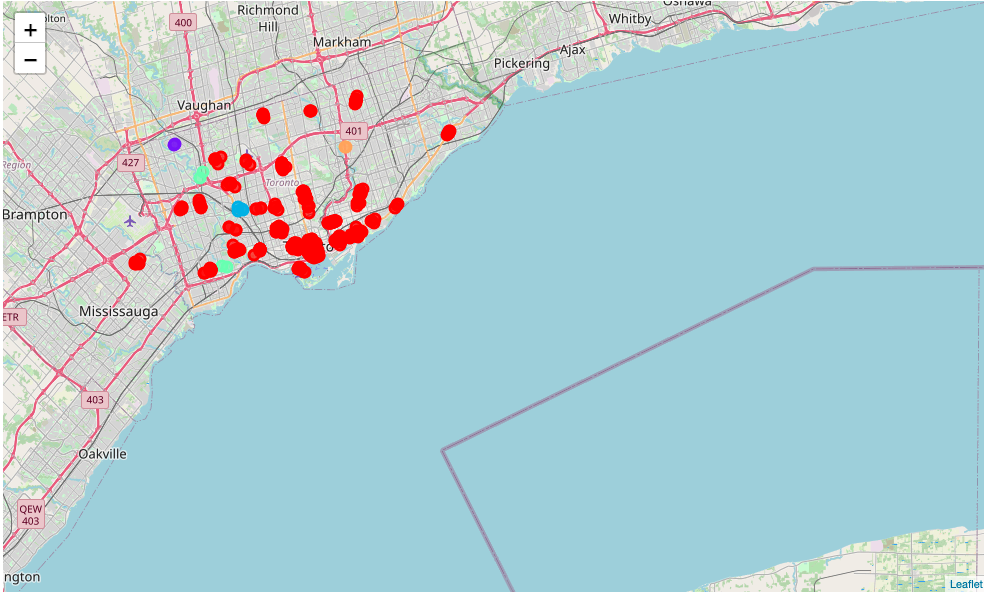

In [93]:
#Examine the clusters

In [94]:
#Cluster 1

In [92]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Neighborhood Latitude  Venue Longitude                   Venue Category  \
0                43.763573       -79.191151                             Bank   
1                43.763573       -79.191537                Electronics Store   
2                43.763573       -79.191275                       Restaurant   
3                43.763573       -79.190720               Mexican Restaurant   
4                43.763573       -79.193406              Rental Car Location   
5                43.763573       -79.192286                   Medical Center   
6                43.763573       -79.189490                     Intersection   
7                43.763573       -79.190466                   Breakfast Spot   
8                43.692657       -79.264532                             Café   
9                43.692657       -79.262161            General Entertainment   
10               43.692657       -79.262230                     Skating Rink   
11               43.692657       -79.261293                  College Stadium   
12               43.799525       -79.318335               Chinese Restaurant   
13               43.799525       -79.317952                             Bank   
14               43.799525       -79.318475                   Sandwich Place   
15               43.799525       -79.318854             Fast Food Restaurant   
16               43.799525       -79.317985                         Pharmacy   
17               43.799525       -79.318715                      Coffee Shop   
18               43.799525       -79.318113                      Pizza Place   
19               43.799525       -79.318492                      Supermarket   
20               43.799525       -79.318167             Fast Food Restaurant   
21               43.799525       -79.318681                   Breakfast Spot   
22               43.799525       -79.318453                   Discount Store   
23               43.799525       -79.318281                     Burger Joint   
24               43.799525       -79.317203                         Gym Pool   
25               43.799525       -79.320101                       Nail Salon   
26               43.786947       -79.381234               Chinese Restaurant   
27               43.786947       -79.380367                             Bank   
28               43.786947       -79.380751                             Café   
29               43.786947       -79.381090              Japanese Restaurant   
30               43.782736       -79.446098                      Pizza Place   
31               43.782736       -79.446028                         Pharmacy   
32               43.782736       -79.446670                   Discount Store   
33               43.782736       -79.444231                      Coffee Shop   
34               43.782736       -79.446339                    Grocery Store   
35               43.782736       -79.445984                      Supermarket   
36               43.782736       -79.446213                          Butcher   
39               43.737473       -79.470111                          Airport   
40               43.737473       -79.464777                             Park   
41               43.737473       -79.469056                      Snack Place   
42               43.739015       -79.512550                             Bank   
43               43.739015       -79.507821                             Park   
44               43.739015       -79.512053                    Grocery Store   
45               43.739015       -79.512261                    Grocery Store   
46               43.739015       -79.512552                    Shopping Mall   
47               43.739015       -79.503958                            Hotel   
48               43.706397       -79.312913                        Gastropub   
49               43.706397       -79.309279             Gym / Fitness Center   
50               43.706397       -79.312825                         Pharmacy   
51   

In [95]:
#Cluster 2

In [96]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Neighborhood Latitude  Venue Longitude Venue Category  Cluster Labels  \
746              43.756303       -79.567195    Pizza Place               1   
747              43.756303       -79.568638   Intersection               1   

    1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
746          Intersection            Nail Salon                  Café   
747          Intersection            Nail Salon                  Café   

    4th Most Common Venue       5th Most Common Venue 6th Most Common Venue  \
746     Convenience Store  Construction & Landscaping          Concert Hall   
747     Convenience Store  Construction & Landscaping          Concert Hall   

    7th Most Common Venue    8th Most Common Venue 9th Most Common Venue  \
746            Comic Shop  Comfort Food Restaurant       College Stadium   
747            Comic Shop  Comfort Food Restaurant       College Stadium   

    10th Most Common Venue  
746     College Rec Center  
747     College Rec Center

In [98]:
#Cluster 3

In [99]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Neighborhood Latitude  Venue Longitude        Venue Category  \
640              43.691116       -79.474050        Sandwich Place   
641              43.691116       -79.474667        Discount Store   
642              43.691116       -79.479982  Fast Food Restaurant   
643              43.691116       -79.480948  Fast Food Restaurant   

     Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
640               2  Fast Food Restaurant        Discount Store   
641               2  Fast Food Restaurant        Discount Store   
642               2  Fast Food Restaurant        Discount Store   
643               2  Fast Food Restaurant        Discount Store   

    3rd Most Common Venue 4th Most Common Venue       5th Most Common Venue  \
640           Coffee Shop     Convenience Store  Construction & Landscaping   
641           Coffee Shop     Convenience Store  Construction & Landscaping   
642           Coffee Shop     Convenience Store  Construction & Landscaping   
643           Coffee Shop     Convenience Store  Construction & Landscaping   

    6th Most Common Venue 7th Most Common Venue    8th Most Common Venue  \
640          Concert Hall            Comic Shop  Comfort Food Restaurant   
641          Concert Hall            Comic Shop  Comfort Food Restaurant   
642          Concert Hall            Comic Shop  Comfort Food Restaurant   
643          Concert Hall            Comic Shop  Comfort Food Restaurant   

    9th Most Common Venue 10th Most Common Venue  
640       College Stadium     College Rec Center  
641       College Stadium     College Rec Center  
642       College Stadium     College Rec Center  
643       College Stadium     College Rec Center

In [100]:
#Cluster 4

In [101]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Neighborhood Latitude  Venue Longitude  Venue Category  Cluster Labels  \
729              43.636258       -79.501971            Park               3   
730              43.636258       -79.496266  Baseball Field               3   
748              43.724766       -79.532854  Baseball Field               3   
749              43.724766       -79.529256     Fabric Shop               3   

    1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
729        Baseball Field           Candy Store       Coworking Space   
730        Baseball Field           Candy Store       Coworking Space   
748           Fabric Shop        Baseball Field           Cheese Shop   
749           Fabric Shop        Baseball Field           Cheese Shop   

    4th Most Common Venue 5th Most Common Venue       6th Most Common Venue  \
729        Cosmetics Shop     Convenience Store  Construction & Landscaping   
730        Cosmetics Shop     Convenience Store  Construction & Landscaping   
748    Chinese Restaurant                Church              Clothing Store   
749    Chinese Restaurant                Church              Clothing Store   

    7th Most Common Venue 8th Most Common Venue    9th Most Common Venue  \
729          Concert Hall            Comic Shop  Comfort Food Restaurant   
730          Concert Hall            Comic Shop  Comfort Food Restaurant   
748          Cocktail Bar           Coffee Shop       College Rec Center   
749          Cocktail Bar           Coffee Shop       College Rec Center   

    10th Most Common Venue  
729             Nail Salon  
730             Nail Salon  
748            Candy Store  
749            Candy Store

In [102]:
#Cluster 5

In [103]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Neighborhood Latitude  Venue Longitude     Venue Category  Cluster Labels  \
37              43.753259       -79.332140               Park               4   
38              43.753259       -79.333114  Food & Drink Shop               4   

   1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
37     Food & Drink Shop       Coworking Space     Convenience Store   
38     Food & Drink Shop       Coworking Space     Convenience Store   

         4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
37  Construction & Landscaping          Concert Hall            Comic Shop   
38  Construction & Landscaping          Concert Hall            Comic Shop   

      7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
37  Comfort Food Restaurant       College Stadium    College Rec Center   
38  Comfort Food Restaurant       College Stadium    College Rec Center   

   10th Most Common Venue  
37             Nail Salon  
38             Nail Salon